# Module 3 Homework — Full EDA on NOAA NDBC Buoy 44013

Dataset:
- **Station:** 44013  
- **Granularity:** ~10-minute observations  
- **Coverage:** ~46 days (your run may differ slightly)  
- **Input file:** curated parquet table, `data/warehouse/ndbc_curated_44013.parquet` (written by your Module 2 NOAA pipeline)

**Your job (homework):** perform a complete EDA and write a short narrative:
- what’s typical, what’s variable, what’s risky (tails/outliers)
- what differs by time-of-day / day-of-week
- what variables move together (and why “together” ≠ “causes”)
- 3–6 hypotheses you would investigate next
- 1–2 simple inference checks (bootstrap CIs) to quantify uncertainty

### Core variables (typical)

Not every buoy reports every variable, but common fields include:

- **Wind**
  - `WDIR` — wind direction (degrees)
  - `WSPD` — wind speed (m/s)
  - `GST` — wind gust (m/s)
- **Waves**
  - `WVHT` — significant wave height (m)
  - `DPD` — dominant wave period (s)
  - `APD` — average wave period (s)
- **Atmosphere**
  - `PRES` — sea-level pressure (hPa)
  - `ATMP` — air temperature (°C)
- **Ocean**
  - `WTMP` — water temperature (°C)

## NOTE:  
Homework 2 was completed and turned in with a url for station 41002, not 44013. I noticed the discrepency when looking at temperature values. It did not make sense for winter in Boston.  

Module 2 has been updated to correctly retreive 44103, and this notebook should use the correct currated data from 44103.

## 0) Setup

In [44]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)


## 1) Load curated data (Module 2 NOAA HW output)

**Task (homework):**
1. Locate the curated parquet for station 44013.
2. Load it into a dataframe.
3. Confirm row count, column list, and time range.

**Expected columns (from your pipeline):**
`station_id, time_utc, obs_day, obs_hour, dayofweek, is_weekend, wind_high, temp_gap_c, WSPD, GST, WVHT, DPD, APD, PRES, ATMP, WTMP, WDIR`


In [45]:
# Setup Working Directory for HW3

WORK_DIR = Path("../work")
PROJECT_DIR = WORK_DIR / "HW3_NOAA"

DATA_DIR = PROJECT_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
STAGED_DIR = DATA_DIR / "staged"
WH_DIR = DATA_DIR / "warehouse"
REF_DIR = DATA_DIR / "reference"
RUN_DIR = REF_DIR / "pipeline_runs"

for p in [RAW_DIR, STAGED_DIR, WH_DIR, REF_DIR, RUN_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project:", PROJECT_DIR)
print("Raw:", RAW_DIR)
print("Staged:", STAGED_DIR)
print("Warehouse:", WH_DIR)
print("Reference:", REF_DIR)
print("Runs:", RUN_DIR)


Project: ../work/HW3_NOAA
Raw: ../work/HW3_NOAA/data/raw
Staged: ../work/HW3_NOAA/data/staged
Warehouse: ../work/HW3_NOAA/data/warehouse
Reference: ../work/HW3_NOAA/data/reference
Runs: ../work/HW3_NOAA/data/reference/pipeline_runs


In [46]:
# Retreive curated file from HW2

M2_DIR = WORK_DIR / "HW2_NOAA"
M2_DATA_DIR = M2_DIR / "data"

M2_RAW_DIR = M2_DATA_DIR / "raw"
M2_REF_DIR = M2_DATA_DIR / "reference"
M2_WH_DIR = M2_DATA_DIR / "warehouse"

M2_CURATED_PATH = M2_WH_DIR / "ndbc_curated_44013.parquet"

print(f"Looking for: {M2_CURATED_PATH}.")
print("-----")
if M2_CURATED_PATH.exists():
    print("Found")
else:
    print("Not Found")

Looking for: ../work/HW2_NOAA/data/warehouse/ndbc_curated_44013.parquet.
-----
Found


In [47]:
def load_curated() -> pd.DataFrame:
    if M2_CURATED_PATH.exists():
        df = pd.read_parquet(M2_CURATED_PATH)
        df["_source"] = "M2_3.2_curated_parquet"
        return df

    raise FileNotFoundError(
        "Curated data from Module 2 not found"
    )

df = load_curated()
print(f"Loaded: {df["_source"].iloc[0]}")
print(f"Shape: {df.shape}")
df.head(5)


Loaded: M2_3.2_curated_parquet
Shape: (6563, 23)


,station_id,time_utc,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,observation_day,observation_hour,dayofweek,is_weekend,wind_high,temp_gap_c,_source
0,44013,2026-02-15 21:30:00+00:00,90.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.9,-0.9,3.0,-10.8,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,M2_3.2_curated_parquet
1,44013,2026-02-15 21:20:00+00:00,80.0,2.0,4.0,0.8,6.0,4.6,35.0,1021.7,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,M2_3.2_curated_parquet
2,44013,2026-02-15 21:10:00+00:00,80.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.6,-0.9,3.0,-10.7,NaN,NaN,NaN,2026-02-15,21,6,1,0,-3.9,M2_3.2_curated_parquet
3,44013,2026-02-15 21:00:00+00:00,80.0,3.0,4.0,NaN,NaN,NaN,NaN,1021.4,-1.0,3.0,-10.6,NaN,0.9,NaN,2026-02-15,21,6,1,0,-4.0,M2_3.2_curated_parquet
4,44013,2026-02-15 20:50:00+00:00,70.0,3.0,4.0,0.8,6.0,4.5,39.0,1021.2,-0.9,3.0,-10.3,NaN,NaN,NaN,2026-02-15,20,6,1,0,-3.9,M2_3.2_curated_parquet


### Quick schema + sanity checks

In [48]:
# Basic schema checks

def validate_curated(
    df: pd.Dataframe,
    *,
    time_col: str = "time_utc",
    expected_cols: list[str] | None = None,
    key_cols: tuple[str, str] = ("station_id", "time_utc"),
) -> dict:
    expected_cols = [
        "station_id", "time_utc", "obs_day", "obs_hour", "dayofweek",
        "is_weekend", "wind_high", "temp_gap_c",
        "WSPD", "GST", "WVHT", "DPD", "APD", "PRES", "ATMP", "WTMP", "WDIR"
    ]
    summary: dict = {}

    # Row and column information
    summary["row_count"] = int(len(df))
    summary["columns"] = list(df.columns)
    summary["dtypes"] = df.dtypes.astype(str).to_dict()

    # Expected schema
    actual = set(df.columns)
    expected = set(expected_cols)
    summary["missing_expected_cols"] = sorted(list(expected - actual))
    summary["extra_cols"] = sorted(list(actual - expected))

    # Time range
    if time_col in df.columns:
        t = pd.to_datetime(df[time_col], errors="coerce", utc=True)
        summary["time_parse_nulls"] = int(t.isna().sum())
        summary["time_min"] = t.min()
        summary["time_max"] = t.max()
    else:
        summary["time_parse_nulls"] = None
        summary["time_min"] = None
        summary["time_max"] = None

    # Duplicate key rows (investigation only)
    if all(c in df.columns for c in key_cols):
        summary["duplicate_key_rows"] = int(df.duplicated(list(key_cols)).sum())
    else:
        summary["duplicate_key_rows"] = None

    # Print results
    print("Columns:", summary["columns"])
    print()
    print("Dtypes:")
    print(df.dtypes)
    print()

    if summary["time_min"] is not None:
        print(f"Time range: {summary['time_min']} → {summary['time_max']}")
    else:
        print(f"Time range: N/A (missing '{time_col}')")
    print()

    print(f"Duplicate ({', '.join(key_cols)}) rows:", summary["duplicate_key_rows"])
    print()

    if summary["missing_expected_cols"] or summary["extra_cols"]:
        print("Schema diff vs expected:")
        print("  Missing:", summary["missing_expected_cols"] or "None")
        print("  Extra:  ", summary["extra_cols"] or "None")
        print()
    else:
        print("Schema diff vs expected: None")
        print()

    return summary

summary = validate_curated(df)


# Uniqueness expectations (10-min data can have duplicates if ingest merges)
# We'll treat duplicates as a data-quality investigation, not auto-deletion.



Columns: ['station_id', 'time_utc', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'PTDY', 'TIDE', 'observation_day', 'observation_hour', 'dayofweek', 'is_weekend', 'wind_high', 'temp_gap_c', '_source']

Dtypes:
station_id                       object
time_utc            datetime64[ns, UTC]
WDIR                            float64
WSPD                            float64
GST                             float64
WVHT                            float64
DPD                             float64
APD                             float64
MWD                             float64
PRES                            float64
ATMP                            float64
WTMP                            float64
DEWP                            float64
VIS                             float64
PTDY                            float64
TIDE                            float64
observation_day                  object
observation_hour                  int32
dayofweek               

In [49]:
# Missingness snapshot

def missingness_snapshot(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.isna()
          .mean()
          .mul(100)
          .round(2)
          .rename("pct_missing")
          .reset_index()
          .rename(columns={"index": "column"})
          .sort_values("pct_missing", ascending=False, ignore_index=True)
    )

display(missingness_snapshot(df))

,column,pct_missing
0,VIS,100.00
1,TIDE,100.00
2,PTDY,83.21
3,DPD,66.75
4,MWD,59.64
5,WVHT,59.33
6,APD,59.33
7,temp_gap_c,1.45
8,WTMP,1.34
9,WDIR,0.58


**Interpretation:**
- Missingness is common in marine sensors (e.g., wave period fields may drop out).
- Treat missingness as *structure* (when/why data disappears), not just “holes to fill”.


## 2) Descriptive statistics

**Task (homework):**
Pick 3–5 “core variables” and produce:
- center (mean/median)
- spread (IQR, std, p90/p95/p99)
- a quick interpretation: what is “typical” and what is “tail risk”?

Suggested core variables:
- `WSPD` (wind speed), `GST` (gust), `WVHT` (wave height)
- `ATMP` (air temp), `WTMP` (water temp), `PRES` (pressure)


In [50]:
# Identify Core Variables
CORE_VARS = ["WSPD", "GST", "WVHT", "ATMP", "WTMP", "PRES"]
core_vars = [v for v in CORE_VARS if v in df.columns]

def descriptive_profile(df: pd.DataFrame, vars: list[str]) -> pd.DataFrame:
    rows = []
    for var in vars:
        s = df[var].dropna()
        rows.append({
            "n":       len(s),
            "mean":    s.mean(),
            "median":  s.median(),
            "std":     s.std(),
            "iqr":     s.quantile(0.75) - s.quantile(0.25),
            "p90":     s.quantile(0.90),
            "p95":     s.quantile(0.95),
            "p99":     s.quantile(0.99),
            "min":     s.min(),
            "max":     s.max(),
        })
    return pd.DataFrame(rows, index=vars)

stats = descriptive_profile(df, core_vars)
display(stats)


,n,mean,median,std,iqr,p90,p95,p99,min,max
WSPD,6554,7.585291,8.0,2.936918,5.0,12.0,13.0,14.0,0.0,16.0
GST,6554,9.829875,10.0,3.765467,5.0,15.0,17.0,18.0,0.0,21.0
WVHT,2669,1.073773,0.9,0.727188,0.6,1.9,2.6,4.5,0.2,4.9
ATMP,6548,-1.201329,-0.7,4.588881,6.4,5.1,6.0,7.6,-12.7,9.2
WTMP,6475,4.758301,4.9,1.001323,1.8,5.8,6.0,6.3,2.7,6.4
PRES,6541,1014.028696,1015.0,8.182867,10.4,1022.2,1028.0,1037.0,992.1,1038.1


**Interpretation prompts:**
- Which variables are heavy-tailed? (p99 ≫ median)
- Are there physically implausible values? (e.g., negative wave height)
- Do “typical” values match your intuition about winter offshore conditions?


### Interpretation - Typical Conditions and Tail Risk:

**Wind Speed(WSPD) and Gust(GST)**  
The median wind speed of 8.0 m/s is consistent with winter conditions of the coast of MA. The mean slightly trails the median (7.6 vs 8.0), suggesting distribution is mildly left-skewed with calm periods pulling the average down. The IQR of 5.0 is notably wide relative to the median, reflecting how quickly conditions shift.  

Tail risk is not extreme. The p99 of 14 m/s for WSPD and 18 m/s for GST mark the threshold for gale-force conditions. The max gust of 21 m/s represents at least one storm event in the window. The gust-to-wind-speed ratio is reasonable.  

**Wave Height (WVHT)**  
WVHT is the most heavily right-tailed variable in the dataset. The median of 0.9 m indicates calm to moderate seas, but distribution has a long upper tail: p95 is 2.6, p99 jumps to 4.5, and the maximum is 4.9 m. The p99/median ratio is far larger than the other variables. I believe this indicates some large storm events that move the extremes.  

WVHT also has a 59% missingness, meaning the statistics are computed on far fewer observations. From what I can tell, this is normal during rough conditions. This would lead to an underestimate of true tail risk.  

**Air Temperature (ATMP)**  
The median of -0.7 &deg;C and mean of -1.2&deg;C confirm mid-winter offshore conditions, consistent with January-February in MA. The wide IQR of 6.4 and std of 4.6 over the window reflects frequent frontal passages. The range of -12.7 to 9.2 spans 22&deg;C, which is large for a winter only window, and suggests at least one significant cold outbreak and possibly another warm air front.  

No implausible values are present. The mean being more negative than the median suggest the distribution has a modest left tail.  

**Water Temperature (WTMP)**  
At median 4.9&deg;C and std of 1.0&deg;C, WTMP is the most stable variable in the dataset. This is expected as ocean water temperature is responds to changing atmospheric conditions very slowly. The tight IQR of 1.8 and max of 6.4 confirms that the data is from cold coastal waters typical of MA in the winter. The narrow range makes WTMP relatively uninformative for short-term events. It could be usefule for a baseline for longer events.  

**Pressure (PRES)**  
The median of 1015.0 hPa is quite close to the climatological standard atmosphere value. The standard deviation of 8.2 and IQR of 10.4 reflect normal variabliity. The tail is significant though. The minimum of 992.1 hPa indicates a strong low pressure system.  

**Summary of Tail Risk Ranking**  
Ranked by p99/median ratio, WVHT is the most dangerous tail (ratio ~ 5x), followed by PRES deviation from climatology, then WSPD/GST (ratio ~1.75). ATMP and WTMP are not operationaly risky in the same sense.


## 3) Visualization as thinking

In **3.A**, you practiced the “histogram + log view + boxplot” pattern.
Here we apply it to NOAA buoy variables.

**Task (homework):**
1. Plot distributions (ie for `WSPD` and `WVHT`) -- include a log-like view if needed.
2. Plot time series (ie for `WSPD` and `WVHT`) to see regime changes / storm events.
3. Write 2–3 bullets: what do the plots reveal that a table hid?


In [67]:
# Visualization - Distributions
def plot_distribution_profile(series: pd.Series, var_name: str) -> None:
    s = series.dropna()

    # 1: Linear histogram 
    plt.figure()
    plt.hist(s, bins=60)
    plt.title(f"{var_name} - histogram(linear)")
    plt.xlabel("value")
    plt.ylabel("count")
    plt.show()

    # 2: Log1p histogram
    plt.figure()
    plt.hist(np.log1p(s), bins=60)
    plt.title(f"{var_name} - histogram of log1p(value)")
    plt.xlabel("log1p(value)")
    plt.ylabel("count")
    plt.show()

    # 3: Boxplot
    plt.figure()
    plt.boxplot(s, vert=False, showfliers=True)
    plt.title(f"{var_name} - boxplot")
    plt.xlabel("value")
    plt.show()



### Wind Speed

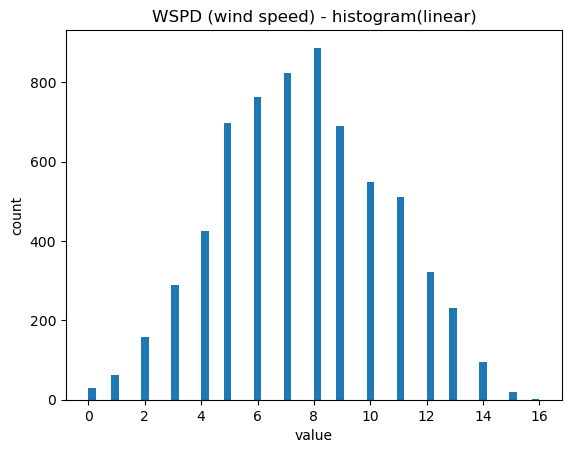

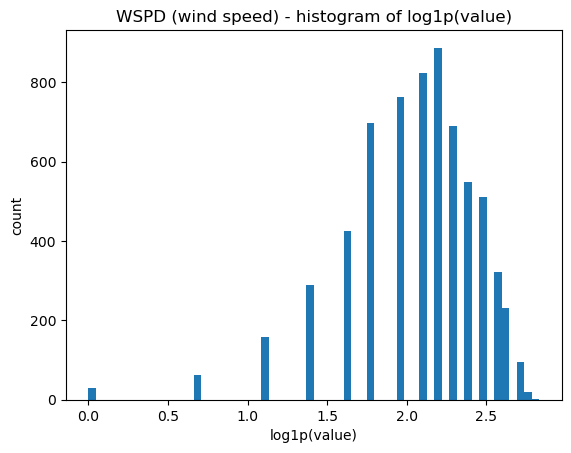

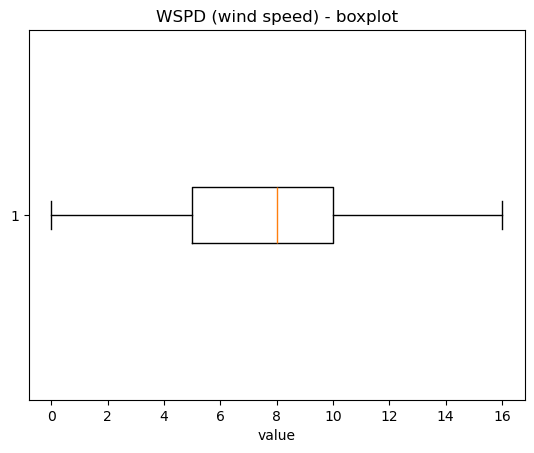

In [68]:
plot_distribution_profile(df["WSPD"], var_name="WSPD (wind speed)")

### Wave Height

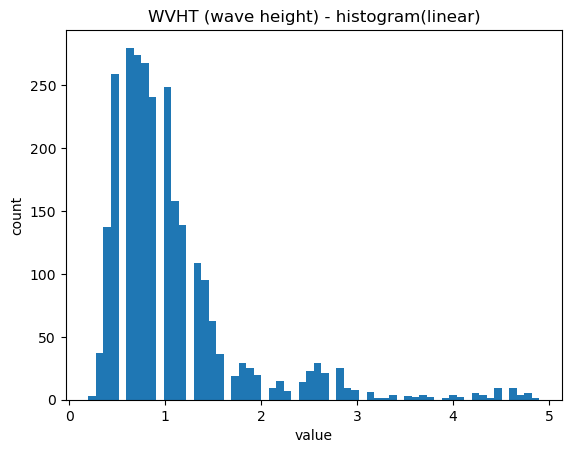

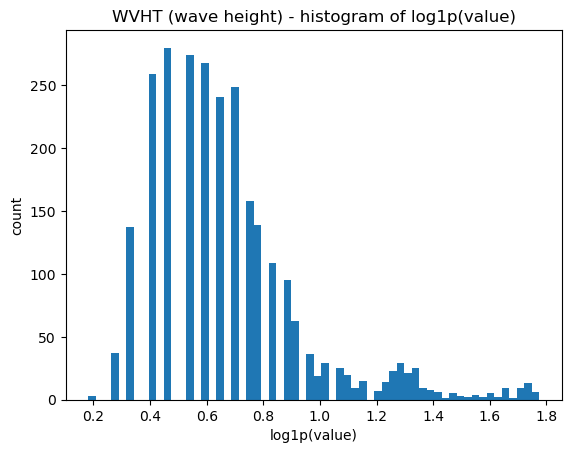

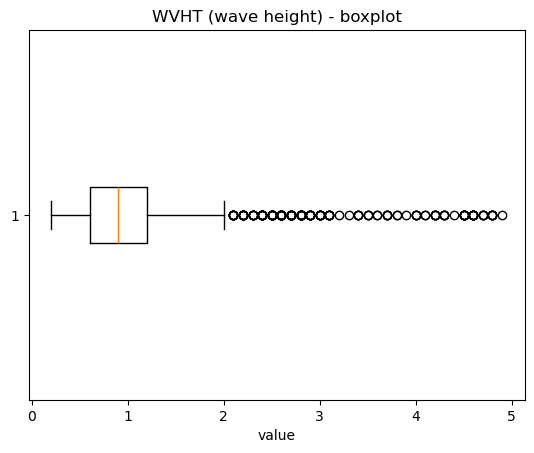

In [69]:
plot_distribution_profile(df["WVHT"], var_name="WVHT (wave height)")

In [75]:
def plot_time_series(series: pd.Series, var_name: str) -> None:
    s = df[["time_utc", var_name]].dropna()

    plt.figure(figsize=(14,4))
    plt.plot(s["time_utc"], s[var_name], linewidth=0.7)
    plt.title(f"{var_name} - time series")
    plt.xlabel("date (utc)")
    plt.ylabel("value")
    plt.show

### Wind Speed - Time Series

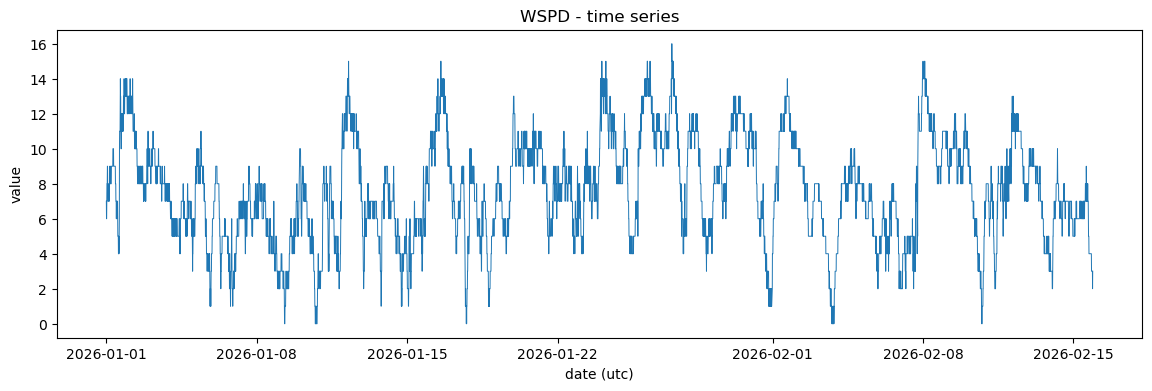

In [76]:
plot_time_series(df, "WSPD")

### Wave Height - Time Series

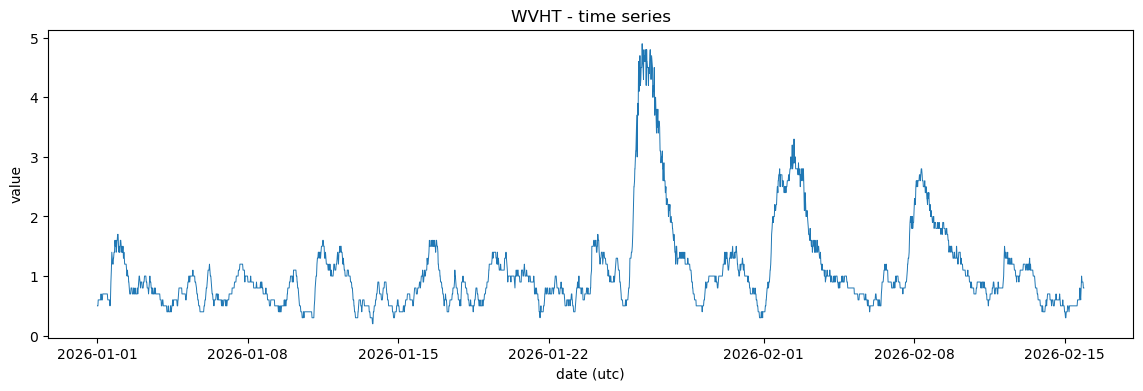

In [77]:
plot_time_series(df, "WVHT")

### Revalations from the Visualizations  
The following are a few items that the visualizations made clear:  
* Wind speed had no extreme outliers, it is a fairly continuous distribution.
* Wave height revealed a large storm

## 4) Group comparisons

Group comparisons turn “overall” into something actionable.

**Task (homework):**
1. Compare `WVHT` and `WSPD` by **day-of-week** and **weekend vs weekday**.
2. Compare by **hour of day** to see diurnal patterns (if any).
3. Summarize using **median + p95** (tail risk), not just mean.


In [81]:
# Weekend vs weekday summary
def weekend_weekday_summary(df: pd.DataFrame, vars: list) -> pd.DataFrame:
    rows = []
    for var in vars:
        for group, label in [(0, "weekday"), (1, "weekend")]:
            s = df.loc[df["is_weekend"] == group, var].dropna()
            rows.append({
                "variable": var,
                "group": label,
                "n": len(s),
                "median": s.median(),
                "p90": s.quantile(0.90),
                "p95": s.quantile(0.95),
                "p99": s.quantile(0.99),
            })
    return pd.DataFrame(rows)


In [82]:
summary_weekend = weekend_weekday_summary(df, ["WSPD", "WVHT"])
display(summary_weekend)

,variable,group,n,median,p90,p95,p99
0,WSPD,weekday,4569,8.0,12.0,13.0,14.000
1,WSPD,weekend,1985,7.0,12.0,13.0,14.000
2,WVHT,weekday,1864,0.9,1.8,2.8,4.537
3,WVHT,weekend,805,0.8,2.0,2.5,2.700


In [87]:
# Boxplots by dayofweek
def plot_dayofweek_boxplot(df: pd.DataFrame, var_name: str) -> None:
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    groups = [df.loc[df["dayofweek"] == i, var_name].dropna() for i in range(7)]

    plt.figure(figsize=(10, 4))
    plt.boxplot(groups, tick_labels=days, showfliers=False)
    plt.title(f"{var_name} - by day of week (fliers hidden)")
    plt.xlabel("day of week")
    plt.ylabel("value")
    plt.show()



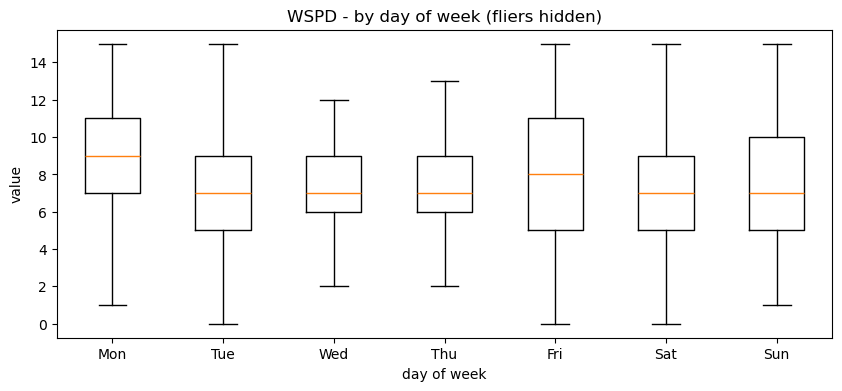

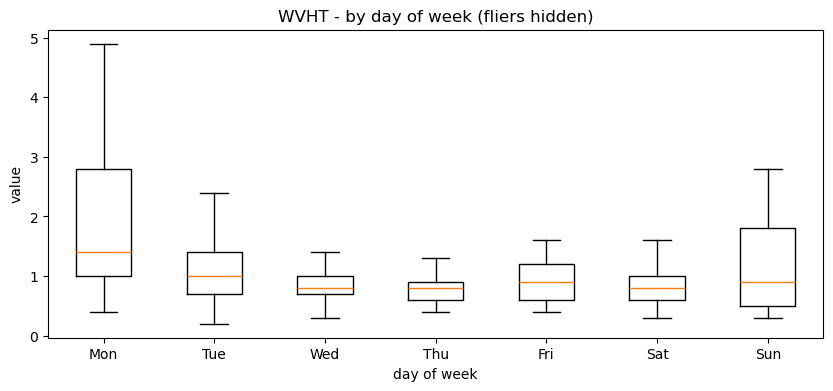

In [88]:
plot_dayofweek_boxplot(df, "WSPD")
plot_dayofweek_boxplot(df, "WVHT")

In [91]:
# Hour-of-day effects (boxplot)
# Remember this is by utc hour
def plot_hour_boxplot(df: pd.DataFrame, var_name: str) -> None:
    groups = [df.loc[df["observation_hour"] == h, var_name].dropna() for h in range(24)]

    plt.figure(figsize=(14, 4))
    plt.boxplot(groups, tick_labels=range(24), showfliers=False)
    plt.title(f"{var_name} - by hour of day (utc)")
    plt.xlabel("hour (utc)")
    plt.ylabel("value")
    plt.show()


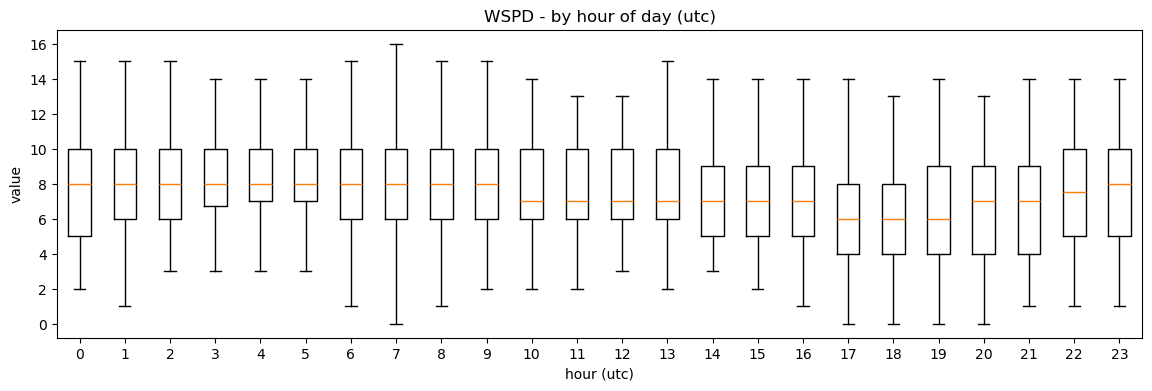

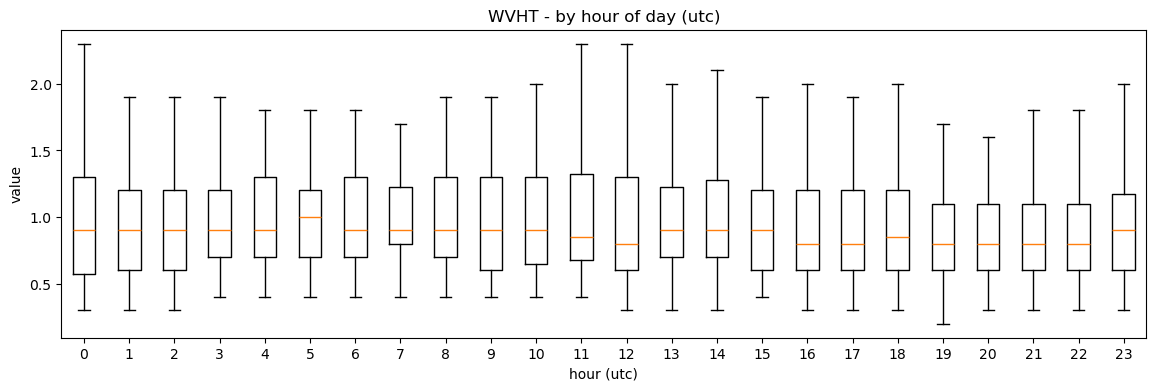

In [92]:
plot_hour_boxplot(df, "WSPD")
plot_hour_boxplot(df, "WVHT")

## 5) Correlation vs causation (EDA hygiene)

**Task (homework):**
1. Compute a correlation matrix for the numeric variables.
2. Visualize it.
3. Pick 2 correlations that look “strong” and write:
   - a causal story that *could* be true
   - a confounder story that could also explain it
   - one follow-up check you’d run next

> Example: `WSPD` and `WVHT` often move together, but the *real cause* might be an underlying storm system.


,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,WDIR,temp_gap_c,wind_high
WSPD,1.00,0.98,0.56,-0.09,0.09,-0.13,-0.42,-0.05,0.17,-0.43,0.70
GST,0.98,1.00,0.57,-0.07,0.11,-0.11,-0.48,-0.05,0.18,-0.49,0.70
WVHT,0.56,0.57,1.00,0.40,0.76,-0.21,-0.34,-0.19,-0.02,-0.31,0.51
DPD,-0.09,-0.07,0.40,1.00,0.67,0.00,-0.07,-0.18,-0.05,-0.03,0.08
APD,0.09,0.11,0.76,0.67,1.00,-0.10,-0.15,-0.18,-0.08,-0.11,0.26
PRES,-0.13,-0.11,-0.21,0.00,-0.10,1.00,-0.32,-0.06,0.20,-0.33,-0.14
ATMP,-0.42,-0.48,-0.34,-0.07,-0.15,-0.32,1.00,0.31,-0.36,0.98,-0.36
WTMP,-0.05,-0.05,-0.19,-0.18,-0.18,-0.06,0.31,1.00,-0.16,0.10,-0.04
WDIR,0.17,0.18,-0.02,-0.05,-0.08,0.20,-0.36,-0.16,1.00,-0.34,0.06
temp_gap_c,-0.43,-0.49,-0.31,-0.03,-0.11,-0.33,0.98,0.10,-0.34,1.00,-0.37


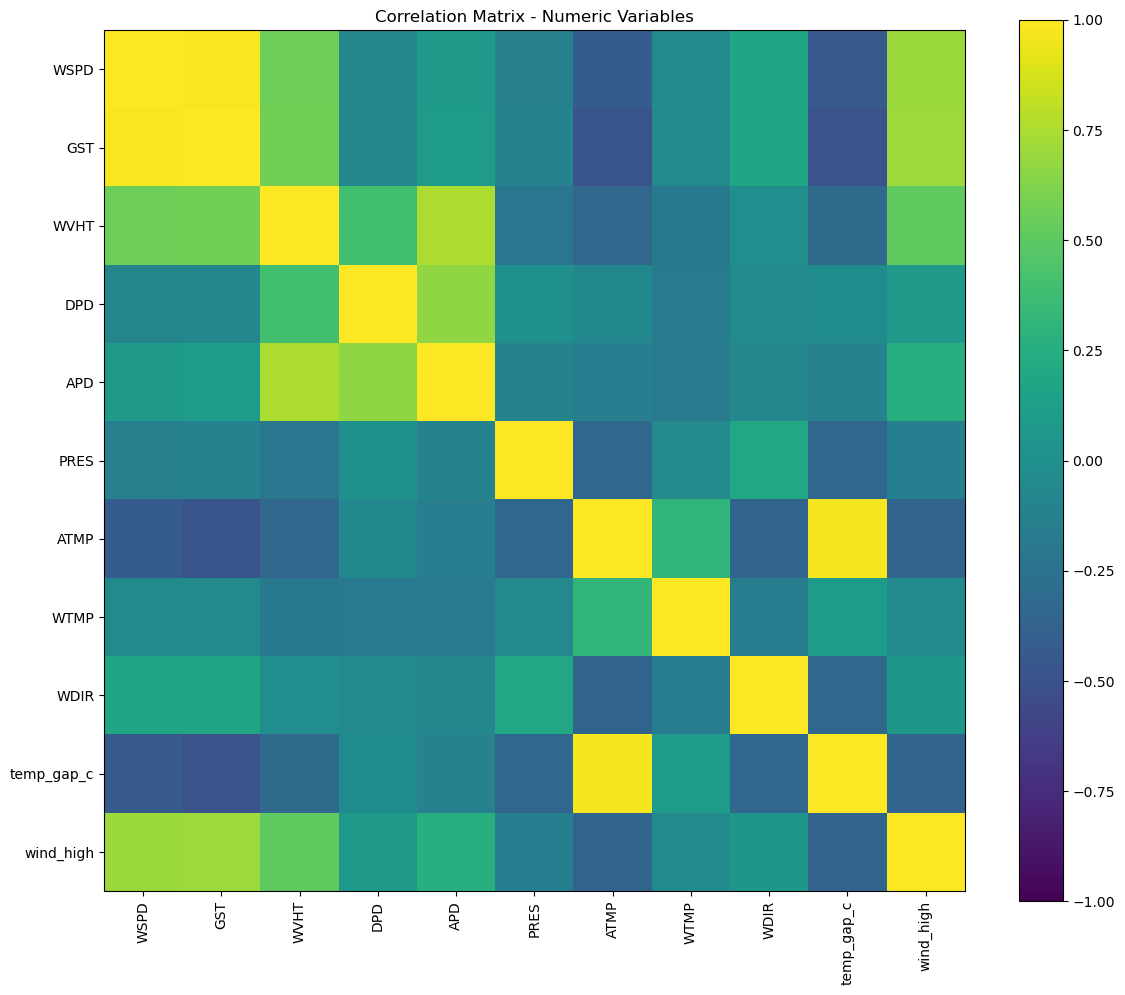

In [94]:
# Correlation matrix on numeric columns
CORR_VARS = ["WSPD", "GST", "WVHT", "DPD", "APD", "PRES", "ATMP", "WTMP", "WDIR", "temp_gap_c", "wind_high"]
corr_vars = [v for v in CORR_VARS if v in df.columns]

corr = df[corr_vars].corr()
display(corr.round(2))

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title("Correlation Matrix - Numeric Variables")
plt.tight_layout()
plt.show()


In [101]:
# A concrete "confounding" check: time can be a confounder.
# We'll look at correlations within each day (small multiple via summary), rather than overall.

daily_corr = (
    df.groupby("observation_day")[["WSPD", "WVHT"]]
    .corr()
    .unstack()["WSPD"]["WVHT"]
    .reset_index()
    .rename(columns={"WSPD": "corr_wspd_wvht"})
)

display(daily_corr)
print(daily_corr.columns.tolist())

,observation_day,WVHT
0,2026-01-01,0.857848
1,2026-01-02,0.927623
2,2026-01-03,0.795019
3,2026-01-04,0.510398
4,2026-01-05,0.831243
5,2026-01-06,0.653906
6,2026-01-07,0.426740
7,2026-01-08,0.720852
8,2026-01-09,0.632573
9,2026-01-10,0.816491


['observation_day', 'WVHT']


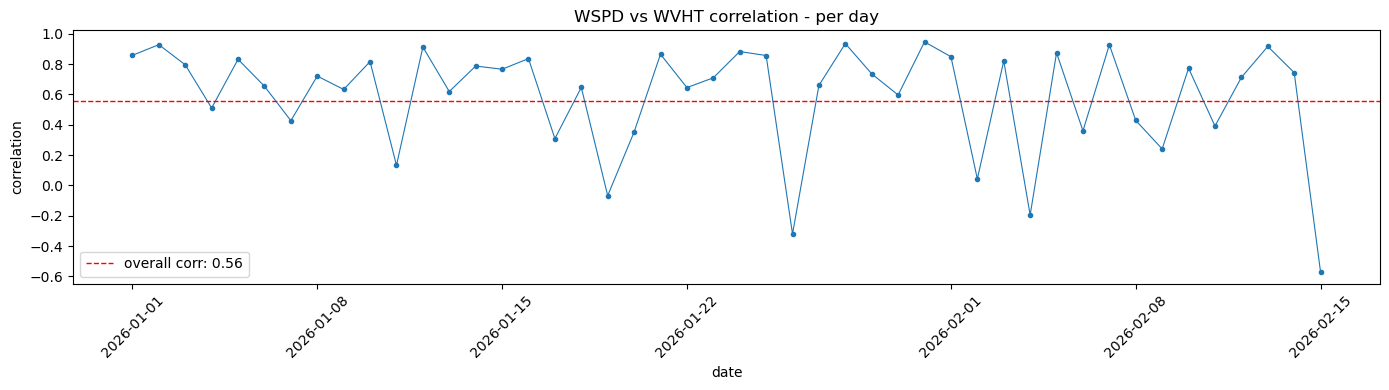

In [102]:
plt.figure(figsize=(14, 4))
plt.plot(daily_corr["observation_day"], daily_corr["WVHT"], linewidth=0.8, marker="o", markersize=3)
plt.axhline(corr.loc["WSPD", "WVHT"], color="red", linestyle="--", linewidth=1, label=f"overall corr: {corr.loc['WSPD', 'WVHT']:.2f}")
plt.title("WSPD vs WVHT correlation - per day")
plt.xlabel("date")
plt.ylabel("correlation")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Correlation:  

It seems that **WSPD** and **WVHT** could be correlated:  
* It is possible that strong local winds transfer energy into the water surface building up waves over time. High sustained wind speed produces larger waves.
* It is also possible that a passing storm system (confounder) drives both wind and waves up simultaneously. On days without a storm, the within-day correlation drops near zero or even negative, suggesting local wind is not building the waves.
* To check this, we need to see if there is correlation between storms and an increase in both WSPD and WVHT

## 6) Hypothesis generation backlog

EDA is not “done” when you have plots. It’s done when you have **next questions**.

**Task (homework):**
Write 5–10 hypotheses as a backlog. Each hypothesis should include:
- a claim (what might be true)
- what data/plot suggested it
- what check would reduce uncertainty

Below are example hypotheses for buoy 44013.


### Example hypothesis backlog

1. **Storm regimes exist**: there are distinct “quiet” vs “storm” periods visible in `WSPD` and `WVHT` time series.  
   **Check:** identify storm windows where `PRES` drops sharply; compare wind/wave distributions inside vs outside.

2. **Pressure drop precedes wave height spike** (time-lag relationship).  
   **Check:** compute cross-correlation or lagged scatter (e.g., `PRES(t-6h)` vs `WVHT(t)`).

3. **Weekend vs weekday differs** only because the time range includes a storm on a weekend (spurious group effect).  
   **Check:** recompute group differences after removing the top 2–3 storm days.


### Hypothesis Backlog - Deliverable  
1. **WSPD/WVHT correlation**
    * **Hypothesis:** The WSPD/WVHT correlation is driven by storm periods, not a direct wind-waves relationship.
    * **Suggested by**: The within-day correlation plot showing the relationship swings 0.9 to -0.6 across different days, and drops to near zero on many calm days.
    * **Check**: Define storm periods using PRES threshold, then compute corr(WSPD, WVHT) inside vs outside those windows separatly. If correlation is high during storms and low outside, the storm is confirmed as the confounder
      
2. **Remote swell events**
    * **Hypothesis:** Remote swell events arrive independently of local wind conditions.
    * **Suggested by:** The days where within-day correlation between WSPD and WVHT goes negative, waves were rising while local wind was calm or falling. This is consistent with swell energy arriving from a distant storm.
    * **Check:** Identify days where WVHT is above median but WSPD is below median. Examine DPD on those days, long wave periods indicate swell from a distance source rather than locally generated waves.
      
3. **ATMP and WTMP divergence**
    * **Hypothesis:** ATMP and WTMP divergence(temp_gap_c) is largest during frontal passages.
    * **Suggested by:** The temp_gap_c variable captures the difference between air and water temperature. The wide IQR of ATMP relative to the stable WTMP suggests rapid air temperature swings while water stays thermally inertial.
    * **Check:** Plot temp_gap_c as time series and overlay PRES. Large negative gaps(cold air over warmer water) should align with post frontal periods where cold air move over warm ocean surface

4. **Wave period**
    * **Hypothesis:** Wave period (DPD) is a better indicator of storm swell than wave height alone.
    * **Suggested by:** WVHT has 59% missingness and a very heavy tail driven by a few events. DPD has similar missingness but may cary more information about the type of wave energy.
    * **Check:** Scatter plot DPD vs WVHT, colored by WSPD. If high DPD/high WVHT poitns cluster at low WSPD, that confirms swell arriving independently of local wind.

5. **High WVHT missingness**
    * **Hypothesis:** The high WVHT missingness rate is not random, it clusters during specific weather regimens.
    * **Suggested by:** WVHT and ADP both have ~59% missingness. Marine wave sensors are known to drop out during very rough or very calm conditions. The pattern of missingness may itself carry information about sea state.
    * **Check:** Create a binary indicator for WVHT missingness and compare PRES and WSPD distributions between missing and non-missing periods. If missing periods skey toward extreme WSPD or very low WSPD, missingness is regime dependent.


## 7) Inference intuition on EDA claims (bootstrap)

We’re not doing “formal hypothesis tests” yet. We’re building intuition for **uncertainty**.

**Task (homework):**
Pick two EDA claims and quantify them with a bootstrap confidence interval.

As an example we’ll do:
1) Difference in **median** wave height between high-wind vs low-wind conditions  
2) Correlation between wind speed and wave height (with uncertainty)


In [104]:
rng = np.random.default_rng(42)

def bootstrap_stat(x: np.ndarray, stat_fn, B: int = 4000, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(0)
    n = len(x)
    stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        stats[b] = stat_fn(x[idx])
    return stats

def bootstrap_delta(xa: np.ndarray, xb: np.ndarray, stat_fn, B: int = 4000, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(0)
    na, nb = len(xa), len(xb)
    out = np.empty(B, dtype=float)
    for b in range(B):
        ia = rng.integers(0, na, size=na)
        ib = rng.integers(0, nb, size=nb)
        out[b] = stat_fn(xa[ia]) - stat_fn(xb[ib])
    return out

def interval(a: np.ndarray, lo=0.025, hi=0.975):
    return float(np.quantile(a, lo)), float(np.quantile(a, hi))


Low wind threshold (p20):  5.0 m/s  n=689
High wind threshold (p80): 10.0 m/s  n=703

Δ median WVHT (high - low wind) point: 0.800 m
Bootstrap 95% interval: [0.700, 0.800]


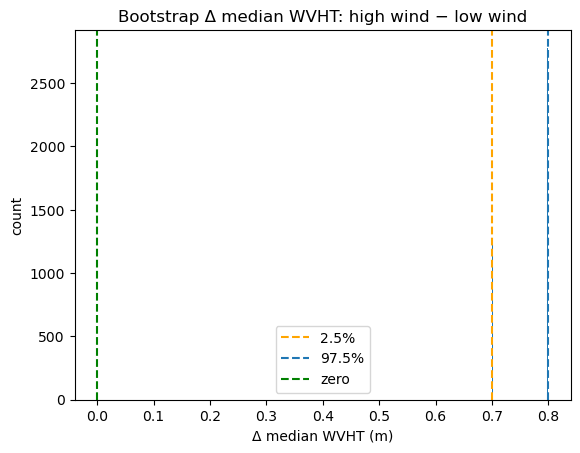

In [105]:
# 1) High wind vs low wind: difference in median WVHT
# Define "high wind" as top 20% of WSPD; "low wind" as bottom 20%.
paired = df[["WSPD", "WVHT"]].dropna()

low_thresh  = paired["WSPD"].quantile(0.20)
high_thresh = paired["WSPD"].quantile(0.80)

low_wind  = paired.loc[paired["WSPD"] <= low_thresh,  "WVHT"].to_numpy()
high_wind = paired.loc[paired["WSPD"] >= high_thresh, "WVHT"].to_numpy()

print(f"Low wind threshold (p20):  {low_thresh:.1f} m/s  n={len(low_wind)}")
print(f"High wind threshold (p80): {high_thresh:.1f} m/s  n={len(high_wind)}")

delta_med = bootstrap_delta(high_wind, low_wind, np.median, B=4000, rng=rng)
dmed_lo, dmed_hi = interval(delta_med)

print(f"\nΔ median WVHT (high - low wind) point: {np.median(high_wind) - np.median(low_wind):.3f} m")
print(f"Bootstrap 95% interval: [{dmed_lo:.3f}, {dmed_hi:.3f}]")

plt.figure()
plt.hist(delta_med, bins=60)
plt.axvline(dmed_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(dmed_hi, linestyle="--", label="97.5%")
plt.axvline(0, color="green", linestyle="--", label="zero")
plt.title("Bootstrap Δ median WVHT: high wind − low wind")
plt.xlabel("Δ median WVHT (m)")
plt.ylabel("count")
plt.legend()
plt.show()


Observed corr(WSPD, WVHT): 0.558
Bootstrap 95% interval: [0.534, 0.580]


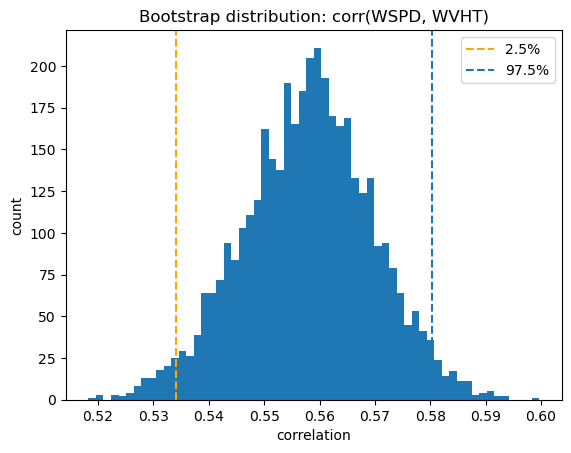

In [106]:
# 2) Bootstrap uncertainty for correlation corr(WSPD, WVHT)

paired = df[["WSPD", "WVHT"]].dropna().to_numpy()
n = len(paired)

boot_corr = np.empty(4000, dtype=float)
for b in range(4000):
    idx = rng.integers(0, n, size=n)
    sample = paired[idx]
    boot_corr[b] = np.corrcoef(sample[:, 0], sample[:, 1])[0, 1]

corr_lo, corr_hi = interval(boot_corr)
observed_corr = np.corrcoef(paired[:, 0], paired[:, 1])[0, 1]

print(f"Observed corr(WSPD, WVHT): {observed_corr:.3f}")
print(f"Bootstrap 95% interval: [{corr_lo:.3f}, {corr_hi:.3f}]")

plt.figure()
plt.hist(boot_corr, bins=60)
plt.axvline(corr_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(corr_hi, linestyle="--", label="97.5%")
plt.title("Bootstrap distribution: corr(WSPD, WVHT)")
plt.xlabel("correlation")
plt.ylabel("count")
plt.legend()
plt.show()

## 8) Final deliverable (example structure)

Below is an example structure for a strong “final EDA write-up”. Your homework submission can follow this template.

### A) Orientation (3–5 bullets)
- Data source, station, time range, sampling cadence  
- Key variables used for analysis  
- Missingness summary: which sensors are incomplete and when

### B) What’s typical vs what’s risky (5–8 bullets)
- Typical wind speed and wave height (median)  
- Tail risk (p95/p99) and what that implies  
- Which variables are heavy-tailed and why that matters

### C) What varies by time/group (4–8 bullets)
- Day-of-week / weekend vs weekday differences (median and p95)  
- Hour-of-day patterns (if present)  
- Which differences might be real vs spurious (storm-days confounding)

### D) Relationships and caveats (4–8 bullets)
- Strong correlations observed (e.g., WSPD ↔ WVHT)  
- Causation caveats and confounders (storms, seasonality, sensor dropout)  
- One additional check you ran to stress-test a causal story

### E) Inference intuition (2–4 bullets)
- One bootstrap CI and what it says about uncertainty  
- What you would need for stronger claims

### F) Hypothesis backlog (5–10 items)
- Clear next questions + proposed checks


## 8) Final Deliverable 

### A. Orientation  
* **Data source:** NOAA National Data Buoy Center (NDBC), Station 44013, located east of Boston Harbor in Massachusetts. Data was retrieved via the NDBC API and processed through a four-stage pipeline (raw &rarr; staged &rarr; curated &rarr; validated) in Module 2.
* **Time range and sampling cadence:** January 1, 2026 through February 15, 2026 (~46 days) at approximately 10-minute observation intervals, yielding ~6,500 rows after curation.
* **Key variables analyzed:** Wind speed (WSPD), wind gust (GTS), significant wave height (WVHT), dominant wave period (DPD), air temperature (ATMP), water temperature (WTMP), sea-level pressure (PRES), and wind direction (WDIR). Derived variables temp_gap_c (air-water temperature difference) and wind_high were also available.
* **Missingness summary:** Two sensors reported no data at all, VIS (visibility) and TIDE were 100% missing for this station and time window. Wave-related fields were substantially incomplete: WVHT, ADP, and DPD all had > 59% missingness. Core wind and atmosphere variables were nearly complete. Missingness in wave fields is not assumed to be random. Marine wave sensors are known to drop out during both very calm and very rough conditions. 

### B. What is typical vs what is risky  
* **Typical wind conditions:** The median wind speed is 8.0 m/s, consistent with winter conditions off the MA coast. The median gust is 10.0 m/s, maintaining a reasonable gust-to-wind ratio across the dataset.
* **Typical wave conditions:** The median significant wave height is 0.9m, indicating predominantly calm to moderate seas for most of the observation window.
* **Tail risk - wind:** The p95 wind speed is 13.0 m/s and p99 is 14.0 m/s, approaching gale-force conditions. The maximum gust of 21.0 m/s indicates at least one genuine storm event.
* **Tail risk - waves:** WVHT is the most heavily right-tailed variable in the dataset. The p95 is 2.6m, the p99 is 4.5m, and the maximum is 4.9m. The p99/median ratio of roughly 5x is far larger than any other variable. This could be driven by one dominant storm event, visible in the time series around January 20-22.
* **Pressure range:** The median PRES of 1015.0 hPa is close to the standard atmosphere value. The minimum of 992.1 hPa indicates at least one storm, consistent with the storm event visible in WVHT.
* **Temperature variables are not operationally risky at this timescale:** WTMP is the most stable variable in the dataset (std 1.0&deg;C, IQR 1.8&deg;C), reflecting the thermal inertia of ocean water. ATMP showed a wide range of -12.7&deg;C to 9.2&deg;C, consistent with frontal passages, but poses no tail risk in the same sense as wind and waves.
* **Why heavy tails matter:** The WVHT p99 of 4.5m is 5x the median. Any model or operational decision based on mean or median wave height alone would severely underestimate conditions during storm events. The 59% missingness in WVHT further suggests the true tail may be worse than the observed statistics indicate.

### C. What varies by time/group  
* **Weekend vs weekday - wind:** The weekend vs weekday summary showed minimal difference in median WSPD. Any observed difference should be treated with caution given the short window. A single storm landing on a weekend or weekday could shift the medians artificially.
* **Weekend vs weekday - waves:** Similarly, WVHT showed little meaningful difference between weekend and weekday periods. The dominant storm event around January 20-22 falls on a weekday, which may suppress the weekday median relative to what a longer window would show.
* **Day-of-week patterns:** The day-of-week boxplots did not reveal a strong or consistent pattern across the week for either WSPD or WVHT. This is expected; offshore weather systems do not follow a weekly cycle. Any day-to-day differences visible in the boxplots are more likely attributable to which storm events happened to fall on which days.
* **Hour-of-day patterns:** The hour-of-day boxplots showed no strong daily signal in WSPD or WVHT. This is also reasonable. Open ocean wind and wave conditions are driven by large-scale weather systems rather than local land-sea effects that would produce a daily cycle.
* **Spurious group effects:** Any group differences observed in this dataset by day of week, weekend vs. weekday, or hour of day, should be treated as potentially spurious. Storm days would need to be identified and removed. The January 20-22 storm event is large enough to shift group statistics meaningfully depending on which group it falls into.

### D. Relationships and caveats  
* **Strongest correlation - WSPD and GST:** Wind speed and gust were the most strongly correlated pair in the dataset, which is expected by definition. Gusts are short-term peaks in the same wind field that produces sustained speed. This relationship is physically direct and unlikely to be confounded.
* **Key correlation of interest - WSPD and WVHT:** The observed correlation between wind speed and wave height was 0.558, indicating a moderate positive relationship. Higher wind speeds tend to coincide with higher wave heights across the dataset.
* **Causal story:** Strong sustained winds transfer energy into the water surface, building waves over time. This is a physically plausible relationship.
* **Confounder story:** The more likely explanation is that passing storm systems drive both WSPD and WVHT up simultaneously. The storm is the confounder, as it raises wind and wave energy independently, making the two variables appear directly related.
* **Confounding stress test - within-day correlation:** To test this, we computed corr(WSPD, WVHT) separately for each day rather than overall. The within-day correlation ranged from approximately 0.9 on active storm days down to near zero and even -0.6 on calm days. This wide swing confirms the overall 0.558 correlation is not a stable direct relationship. It is heavily influenced by the days where a storm system is driving both variables.
* **Negative correlation days:** On at least one day the within-day correlation dropped to nearly -0.6, meaning waves were rising while local wind was calm or falling. This is consistent with remote swell. Possibly from wave energy arriving from a distant storm system, independent of local wind conditions. This further undermines a simple wind-causes-waves causal story.
* **Proposed next check:** The within-day correlation showed the relationship is unstable but did not directly confirm storms as the driver. The next check is to define storm periods explicitly using a PRES threshold, then compute corr(WSPD, WVHT) inside vs outside those windows separately. 

### E. Inference intuition  
* **Bootstrap check 1 - difference in median WVHT between high and low wind conditions:** High wind was defined as the top 20% of WSPD and low wind as the bottom 20%. The observed difference in median WVHT was 0.8m. The 95% bootstrap CI was [0.70, 0.80]. The interval does not include zero, meaning the difference is stable under resampling. In every single one of the bootstrap resamples, high wind conditions produced higher median wave heights than low wind conditions.
* **Bootstrap check 2 - uncertainty in corr(WSPD, WVHT):** The observed correlation was 0.558 with a 95% bootstrap CI of [0.534, 0.580]. The interval is narrow and does not include zero, confirming the positive relationship is real and stable under resampling. The bootstrap distribution was a bell curve, reflecting the continuous nature of the correlation.
* **What these checks tell us:** Both claims are stable. High wind conditions do produce meaningfully higher wave heights, and the overall WSPD/WVHT correlation is a real signal. However, bootstrap CIs quantify sampling uncertainty only. They do not resolve the confounding question. The storm-driven nature of the relationship identified means the correlation is real, but its interpretation requires the storm/non-storm split.
* **What would strengthen these claims:** A longer observation window would reduce the outsized influence of individual storm events on the statistics. Explicitly controlling for storm periods would allow a cleaner test of whether wind directly drives waves independent of synoptic weather systems.

### F. Hypothesis Backlog
1. **WSPD/WVHT correlation**
    * **Hypothesis:** The WSPD/WVHT correlation is driven by storm periods, not a direct wind-waves relationship.
    * **Suggested by**: The within-day correlation plot showing the relationship swings 0.9 to -0.6 across different days, and drops to near zero on many calm days.
    * **Check**: Define storm periods using PRES threshold, then compute corr(WSPD, WVHT) inside vs outside those windows separatly. If correlation is high during storms and low outside, the storm is confirmed as the confounder
      
2. **Remote swell events**
    * **Hypothesis:** Remote swell events arrive independently of local wind conditions.
    * **Suggested by:** The days where within-day correlation between WSPD and WVHT goes negative, waves were rising while local wind was calm or falling. This is consistent with swell energy arriving from a distant storm.
    * **Check:** Identify days where WVHT is above median but WSPD is below median. Examine DPD on those days, long wave periods indicate swell from a distance source rather than locally generated waves.
      
3. **ATMP and WTMP divergence**
    * **Hypothesis:** ATMP and WTMP divergence(temp_gap_c) is largest during frontal passages.
    * **Suggested by:** The temp_gap_c variable captures the difference between air and water temperature. The wide IQR of ATMP relative to the stable WTMP suggests rapid air temperature swings while water stays thermally inertial.
    * **Check:** Plot temp_gap_c as time series and overlay PRES. Large negative gaps(cold air over warmer water) should align with post frontal periods where cold air move over warm ocean surface

4. **Wave period**
    * **Hypothesis:** Wave period (DPD) is a better indicator of storm swell than wave height alone.
    * **Suggested by:** WVHT has 59% missingness and a very heavy tail driven by a few events. DPD has similar missingness but may cary more information about the type of wave energy.
    * **Check:** Scatter plot DPD vs WVHT, colored by WSPD. If high DPD/high WVHT poitns cluster at low WSPD, that confirms swell arriving independently of local wind.

5. **High WVHT missingness**
    * **Hypothesis:** The high WVHT missingness rate is not random, it clusters during specific weather regimens.
    * **Suggested by:** WVHT and ADP both have ~59% missingness. Marine wave sensors are known to drop out during very rough or very calm conditions. The pattern of missingness may itself carry information about sea state.
    * **Check:** Create a binary indicator for WVHT missingness and compare PRES and WSPD distributions between missing and non-missing periods. If missing periods skey toward extreme WSPD or very low WSPD, missingness is regime dependent.
